In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [2]:
!git clone https://github.com/pytorch/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1853 (delta 0), reused 0 (delta 0), pack-reused 1850
Receiving objects: 100% (1853/1853), 38.87 MiB | 14.93 MiB/s, done.
Resolving deltas: 100% (967/967), done.


In [3]:
%cd examples/fast_neural_style

/content/examples/fast_neural_style


In [4]:
!python download_saved_models.py

25020748it [00:03, 7694089.85it/s] 


In [0]:
# !python neural_style/neural_style.py eval --content-image images/content-images/amber.jpg --model saved_models/mosaic.pth --output-image out_amber.jpg --cuda 0

In [0]:
# !ls
# !cat neural_style/neural_style.py 

In [0]:
!ls

download_saved_models.py  neural_style	photo.jpg  saved_models
images			  output.jpg	README.md  saved_models.zip


In [0]:
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx

import neural_style.utils
from neural_style.transformer_net import TransformerNet
from neural_style.vgg import Vgg16

In [0]:
style_model = None

In [0]:
def check_paths(args):
    try:
        if not os.path.exists(args.save_model_dir):
            os.makedirs(args.save_model_dir)
        if args.checkpoint_model_dir is not None and not (os.path.exists(args.checkpoint_model_dir)):
            os.makedirs(args.checkpoint_model_dir)
    except OSError as e:
        print(e)
        sys.exit(1)


def train(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size)

    transformer = TransformerNet().to(device)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16(requires_grad=False).to(device)
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = neural_style.utils.load_image(args.style_image, size=args.style_size)
    style = style_transform(style)
    style = style.repeat(args.batch_size, 1, 1, 1).to(device)

    features_style = vgg(neural_style.utils.normalize_batch(style))
    gram_style = [neural_style.utils.gram_matrix(y) for y in features_style]

    for e in range(args.epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = neural_style.utils.normalize_batch(y)
            x = neural_style.utils.normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = neural_style.utils.gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= args.style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % args.log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if args.checkpoint_model_dir is not None and (batch_id + 1) % args.checkpoint_interval == 0:
                transformer.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
                ckpt_model_path = os.path.join(args.checkpoint_model_dir, ckpt_model_filename)
                torch.save(transformer.state_dict(), ckpt_model_path)
                transformer.to(device).train()

    # save model
    transformer.eval().cpu()
    save_model_filename = "epoch_" + str(args.epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
        args.content_weight) + "_" + str(args.style_weight) + ".model"
    save_model_path = os.path.join(args.save_model_dir, save_model_filename)
    torch.save(transformer.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)


def stylize(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = neural_style.utils.load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)
    global style_model
    if args.model.endswith(".onnx"):
        output = stylize_onnx_caffe2(content_image, args)
    else:
        with torch.no_grad():
            if style_model == None:
              style_model = TransformerNet()
              state_dict = torch.load(args.model)
              # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
              for k in list(state_dict.keys()):
                  if re.search(r'in\d+\.running_(mean|var)$', k):
                      del state_dict[k]
              style_model.load_state_dict(state_dict)
              style_model.to(device)
            if args.export_onnx:
                assert args.export_onnx.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(style_model, content_image, args.export_onnx).cpu()
            else:
                output = style_model(content_image).cpu()
    neural_style.utils.save_image(args.output_image, output[0])


def stylize_onnx_caffe2(content_image, args):
    """
    Read ONNX model and run it using Caffe2
    """

    assert not args.export_onnx

    import onnx
    import onnx_caffe2.backend

    model = onnx.load(args.model)

    prepared_backend = onnx_caffe2.backend.prepare(model, device='CUDA' if args.cuda else 'CPU')
    inp = {model.graph.input[0].name: content_image.numpy()}
    c2_out = prepared_backend.run(inp)[0]

    return torch.from_numpy(c2_out)

In [0]:
# !python neural_style/neural_style.py eval --content-image images/content-images/amber.jpg --model saved_models/mosaic.pth --output-image out_amber.jpg --cuda 0
import time 

def main(img_path):
    args = argparse.Namespace(
        content_image=img_path, 
        content_scale=None, 
        cuda=1, 
        export_onnx=None, 
        model='saved_models/udnie.pth',
        output_image='output.jpg',
        subcommand='eval')

    if args.subcommand is None:
        print("ERROR: specify either train or eval")
        sys.exit(1)
    if args.cuda and not torch.cuda.is_available():
        print("ERROR: cuda is not available, try running on CPU")
        sys.exit(1)

    if args.subcommand == "train":
        check_paths(args)
        train(args)
    else:
        stylize(args)

        

In [12]:
!pwd

/content/examples/fast_neural_style


In [16]:
%cd ../../..


/


In [0]:
!cp 4.jpg /content/examples/fast_neural_style/

In [24]:
%cd /content/examples/fast_neural_style
!ls

/content/examples/fast_neural_style
1.jpg  3.jpg  download_saved_models.py	neural_style  saved_models
2.jpg  4.jpg  images			README.md     saved_models.zip


In [41]:
%%time 
main('4.jpg')

CPU times: user 2.06 s, sys: 1.22 s, total: 3.29 s
Wall time: 3.29 s


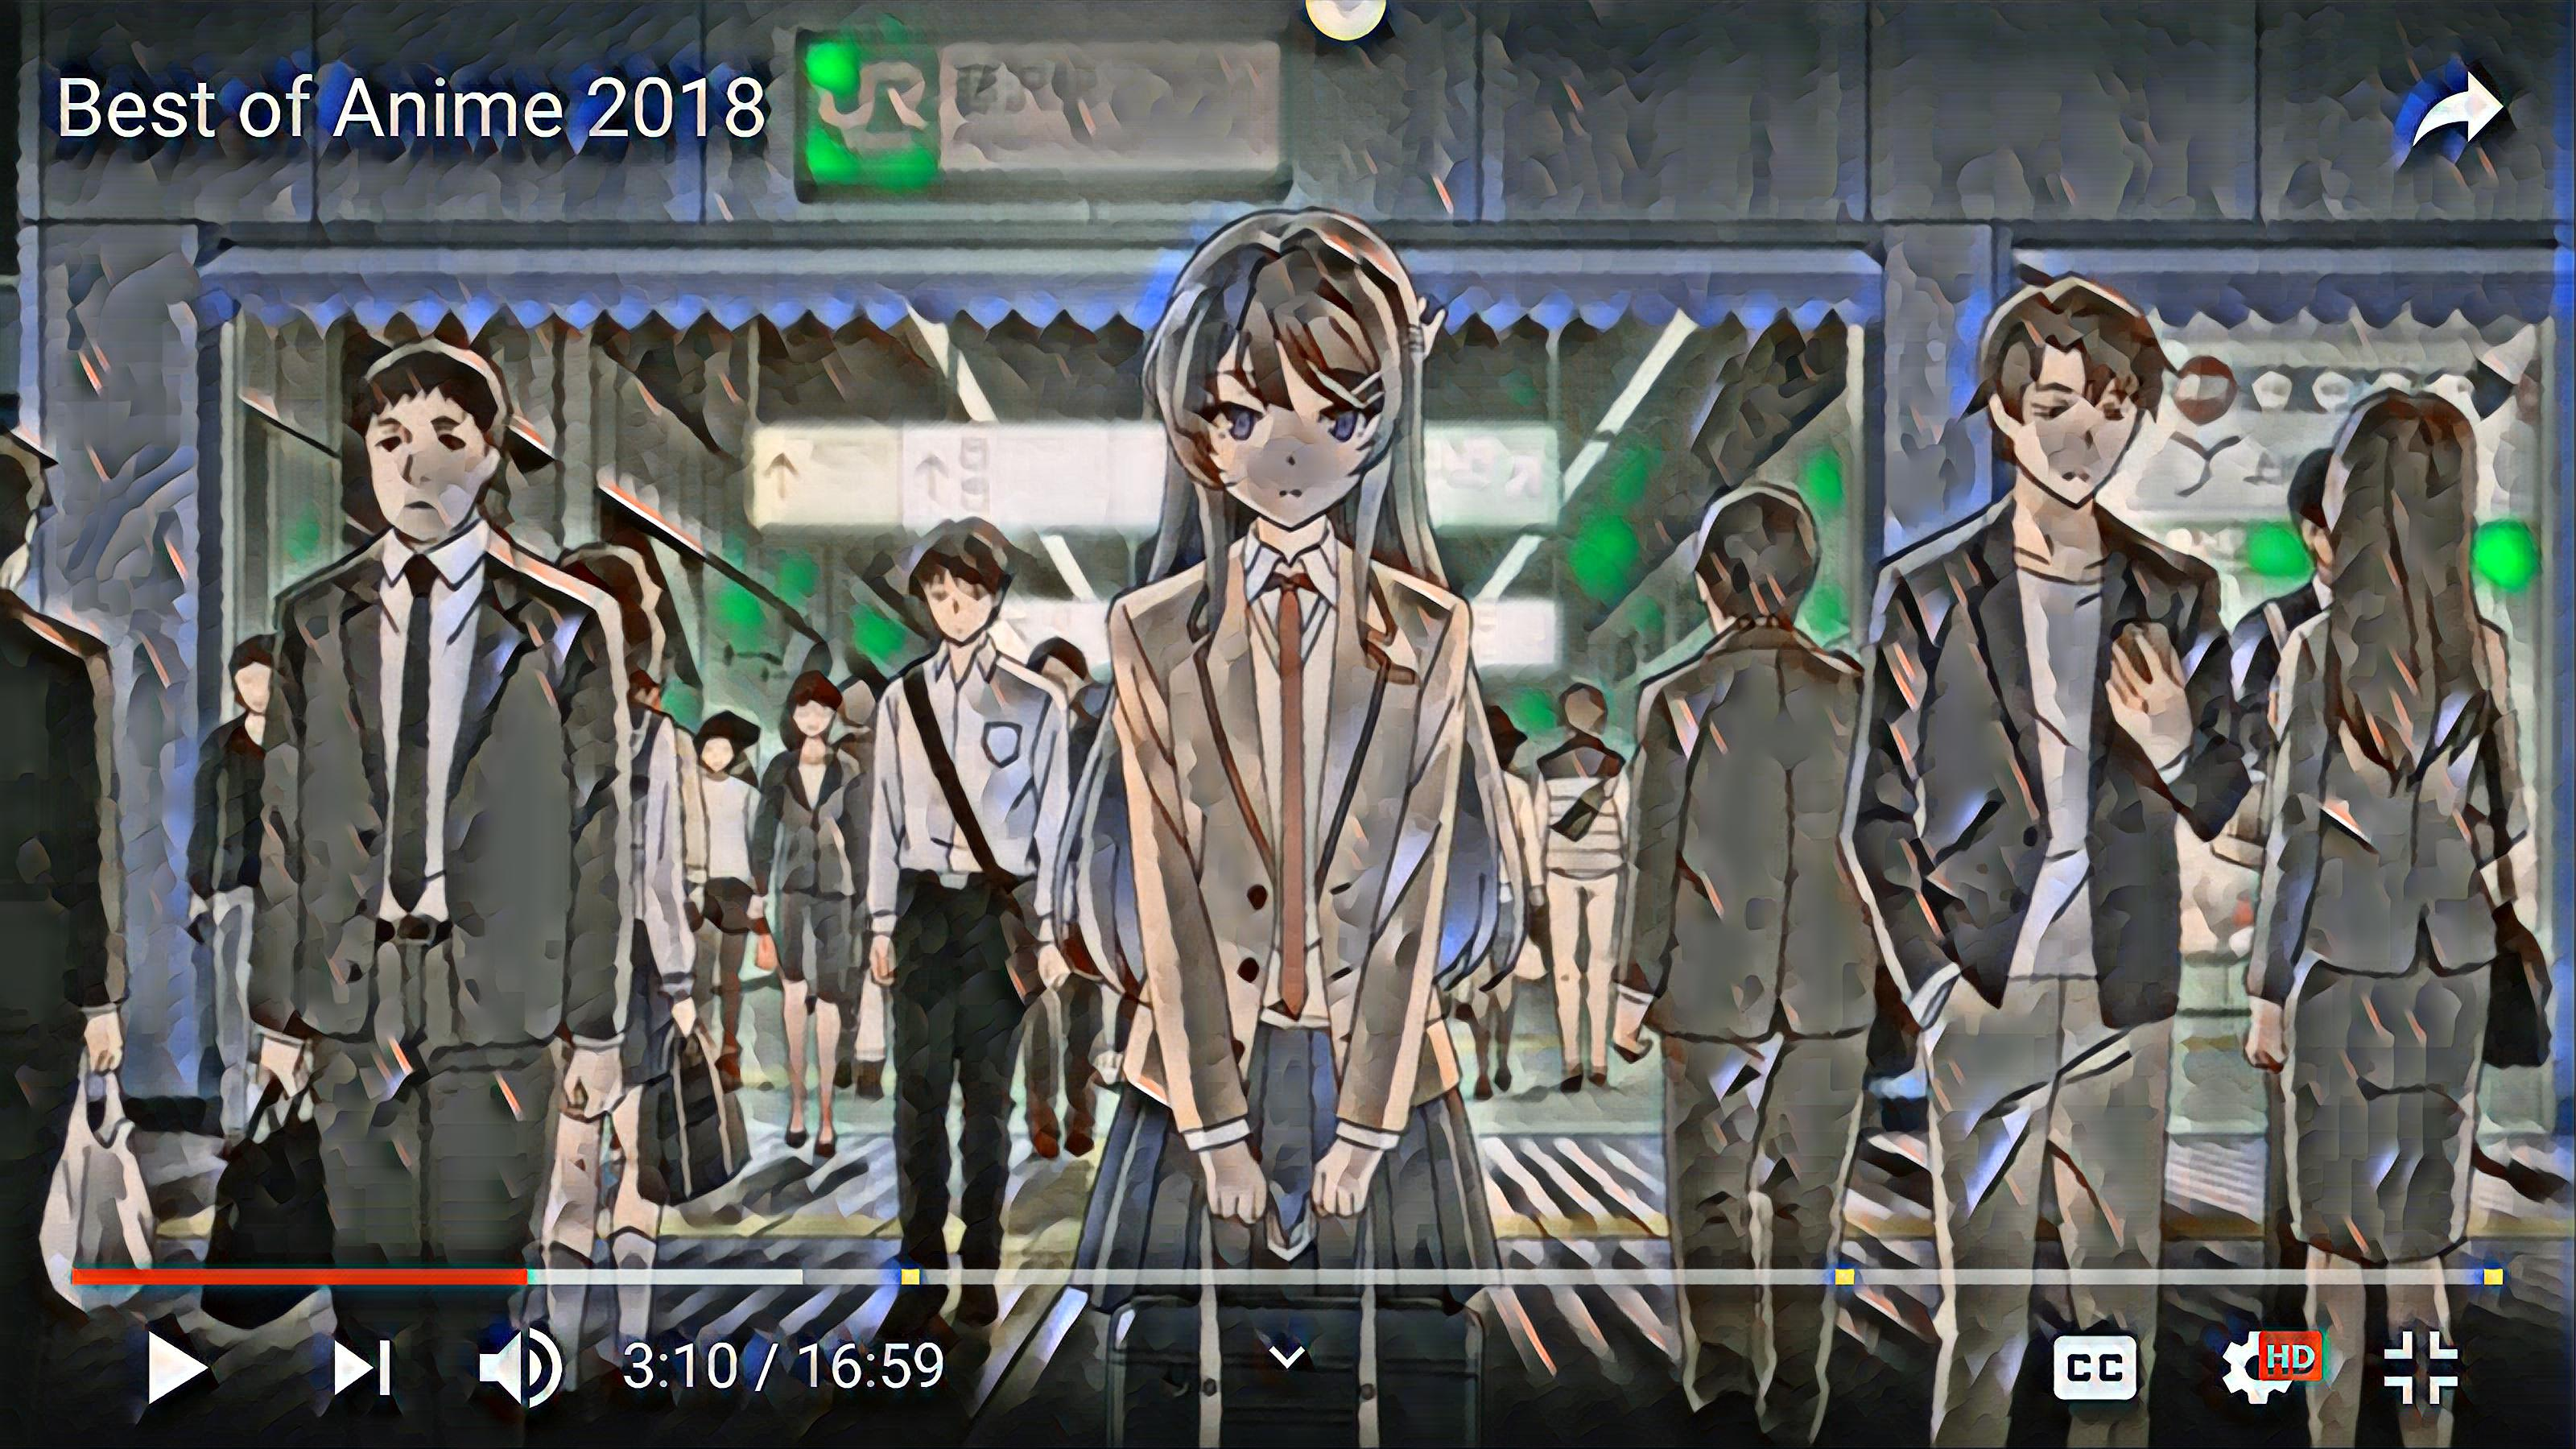

In [42]:
from IPython.display import Image
Image('output.jpg')

In [0]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

VIDEO_HTML = """
<video autoplay
 width=800 height=600></video>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='images/photo.jpg', quality=0.8):
  display(HTML(VIDEO_HTML % quality))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

In [0]:
# take_photo()

In [0]:
# !cd images/content-images && wget https://thumbs.dreamstime.com/z/dublin-ireland-august-city-street-view-pedestrians-dublin-ireland-dublin-ireland-august-city-street-pedestrians-99397617.jpg